## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

## Reading Data

In [2]:
data = pd.read_csv('./ff.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Obtaining data info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data.shape

(6362620, 11)

## Data Cleaning

### Checking for missing values

<AxesSubplot: >

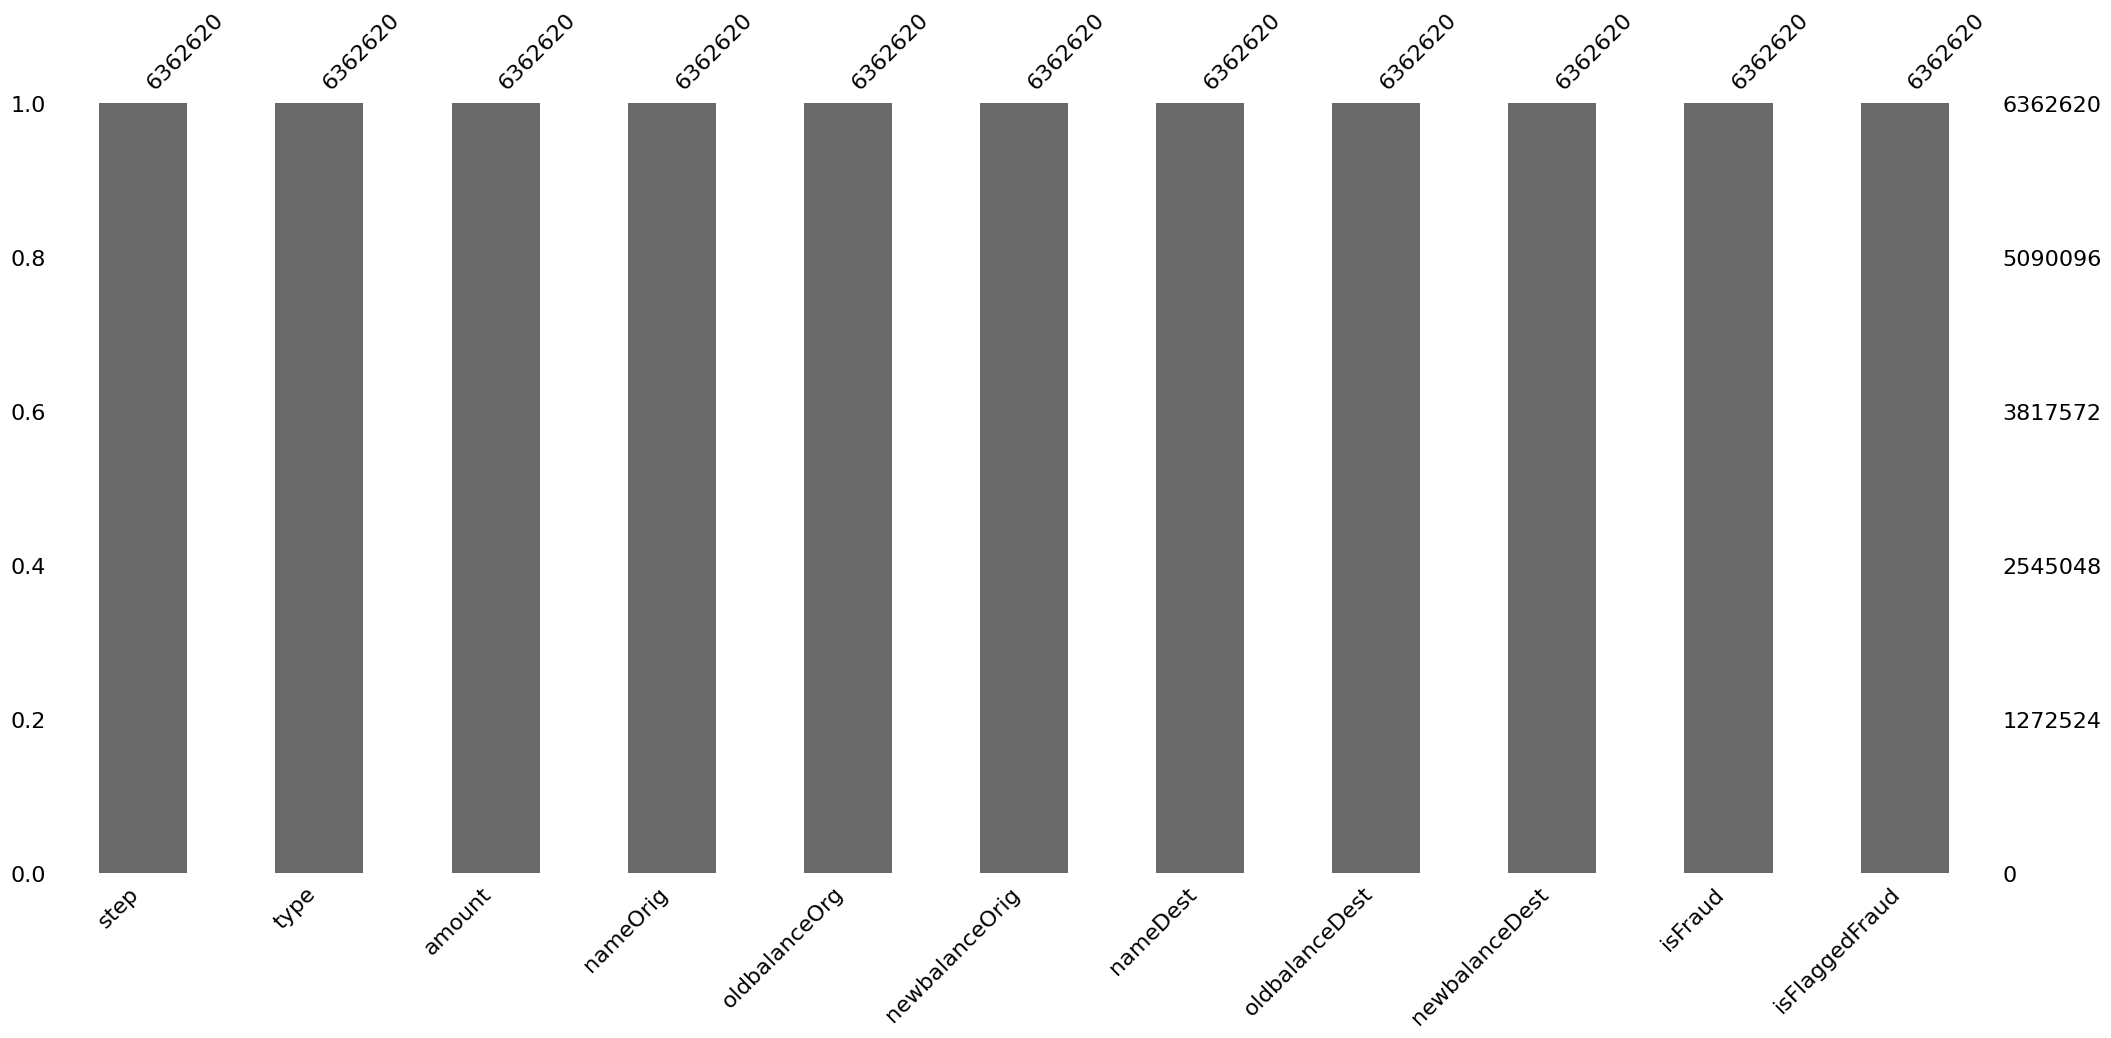

In [6]:
msno.bar(data)

#### All columns show 100% completed data records!

### Number of duplicates in data

In [7]:
data.duplicated().sum()

0

### Renaming columns

In [8]:
data = data.rename(columns = {'nameOrig':'origin', 'oldbalanceOrg':'sender_old_bal', 'newbalanceOrig':'sender_new_bal', 'nameDest':'dest', 'oldbalanceDest':'dest_old_bal', 'newbalanceDest':'dest_new_bal'})

### Removing non-essential columns

In [9]:
data = data.drop(columns = ['step', 'isFlaggedFraud'], axis='columns')

### Viewing modified data

In [10]:
data.head()

,type,amount,origin,sender_old_bal,sender_new_bal,dest,dest_old_bal,dest_new_bal,isFraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## Data Analysis

### Visualizing fraud occurances

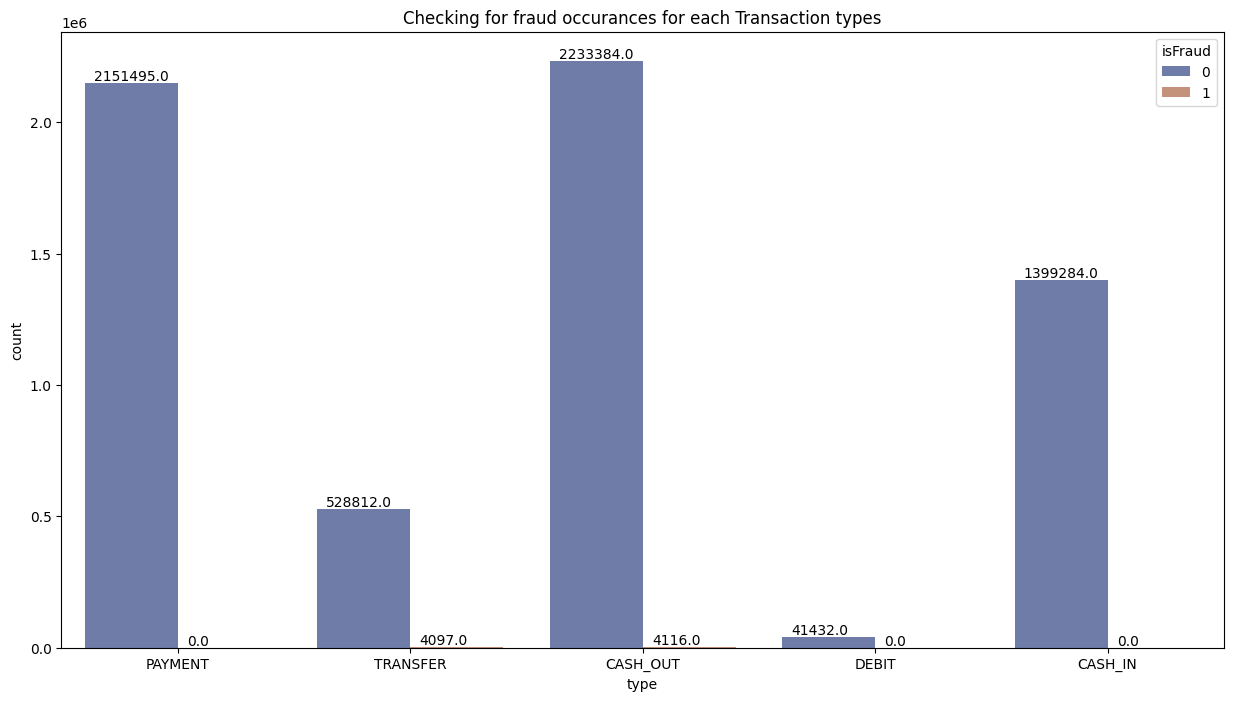

In [11]:
plt.figure(figsize=(15,8))
g = sns.countplot(data=data, x='type', hue='isFraud', palette='dark',alpha=0.6)
plt.title("Checking for fraud occurances for each Transaction types")

#finding counts
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x()+0.04, p.get_height()+10000))

### Accounts involved in fraud transactions

#### Checking origin accounts (and if same account has been used for multiple fraudulent transactions)

##### For type 'Transfer'

In [12]:
transfer_fraud = data[(data['type']=='TRANSFER') & (data['isFraud']==1)]

In [13]:
transfer_fraud['origin'].value_counts()

C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: origin, Length: 4097, dtype: int64

##### For type 'CashOut'

In [14]:
cashOut_fraud = data[(data['type']=='CASH_OUT') & (data['isFraud']==1)]

In [15]:
cashOut_fraud['origin'].value_counts()

C840083671     1
C1055498407    1
C1886113938    1
C520336445     1
C463684846     1
              ..
C1641368956    1
C2120940829    1
C992121519     1
C1663597987    1
C1280323807    1
Name: origin, Length: 4116, dtype: int64

#### Checking destination accounts (and if same account has been used for multiple fraudulent transactions)

##### For type 'Transfer'

In [16]:
transfer_fraud['dest'].value_counts()

C553264065     1
C988859148     1
C1287650869    1
C922180689     1
C131895413     1
              ..
C776246900     1
C1234144009    1
C571016162     1
C1381364691    1
C2080388513    1
Name: dest, Length: 4097, dtype: int64

##### For type 'CashOut'

In [17]:
cashOut_fraud['dest'].value_counts()

C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: dest, Length: 4091, dtype: int64

### Checking if transfer destination account used for cashing out (for fraud cases)

In [18]:
transfer_fraud.dest.isin(cashOut_fraud.origin).any()

False

In [19]:
trans_cashout = data[data['type']=='TRANSFER']

In [20]:
transfer_fraud.dest.isin(trans_cashout.origin).any()

True

In [21]:
transfer_fraud.dest.isin(trans_cashout.origin).count()

4097

### Insights

<ul>
    <li>Fraud Transactions are seen only for 'TRANSFER' (4097 occurances) and 'CASH_OUT' (4116 occurances) types</li>
    <li>Fraud tranasactions are usually to and from customers</li>
    <li>Recipient accounts fraud 'TRANSFER' cases were -</li>
    <ul>
        <li>not involved in any fraudulent cash withdrawals</li>
        <li>4097 times used to make valid cash withdrawals</li>
    </ul>
</ul>

## Feature Engineering

### Creating new column client_type having 4 categories and dropping 'origin' and 'dest'

<ul>
    <li>CC - Customer to Customer</li>
    <li>CM - Customer to Merchant</li>
    <li>MC - Merchant to Customer</li>
    <li>MM - Merchant to Merchant</li>
</ul>

#### Adding 'client_type' column

In [22]:
data['client_type'] = np.nan
data.loc[data.origin.str.contains('C') & data.dest.str.contains('C'), 'client_type'] = 'CC'
data.loc[data.origin.str.contains('C') & data.dest.str.contains('M'), 'client_type'] = 'CM'
data.loc[data.origin.str.contains('M') & data.dest.str.contains('C'), 'client_type'] = 'MC'
data.loc[data.origin.str.contains('M') & data.dest.str.contains('M'), 'client_type'] = 'MM'

#### Dropping 'origin' and 'dest'

In [23]:
data.drop(columns = ['origin', 'dest'], axis = 'columns', inplace = True)

In [24]:
data.head()

,type,amount,sender_old_bal,sender_new_bal,dest_old_bal,dest_new_bal,isFraud,client_type
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,CM
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,CM
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,CC
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,CC
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,CM


## Data Visualization

### Obtaining number of fraud transactions and valid transactions of each 'client_type'

In [25]:
fraudTrans = data[data['isFraud'] == 1]
validTrans = data[data['isFraud'] == 0]

In [26]:
fr = fraudTrans.client_type.value_counts()
print(fr)

CC    8213
Name: client_type, dtype: int64


In [27]:
va = validTrans.client_type.value_counts()
print(va)

CC    4202912
CM    2151495
Name: client_type, dtype: int64


### Visualizing the fraud and valid transaction counts for each 'client_type'

Text(0.5, 1.0, 'Valid Transactions')

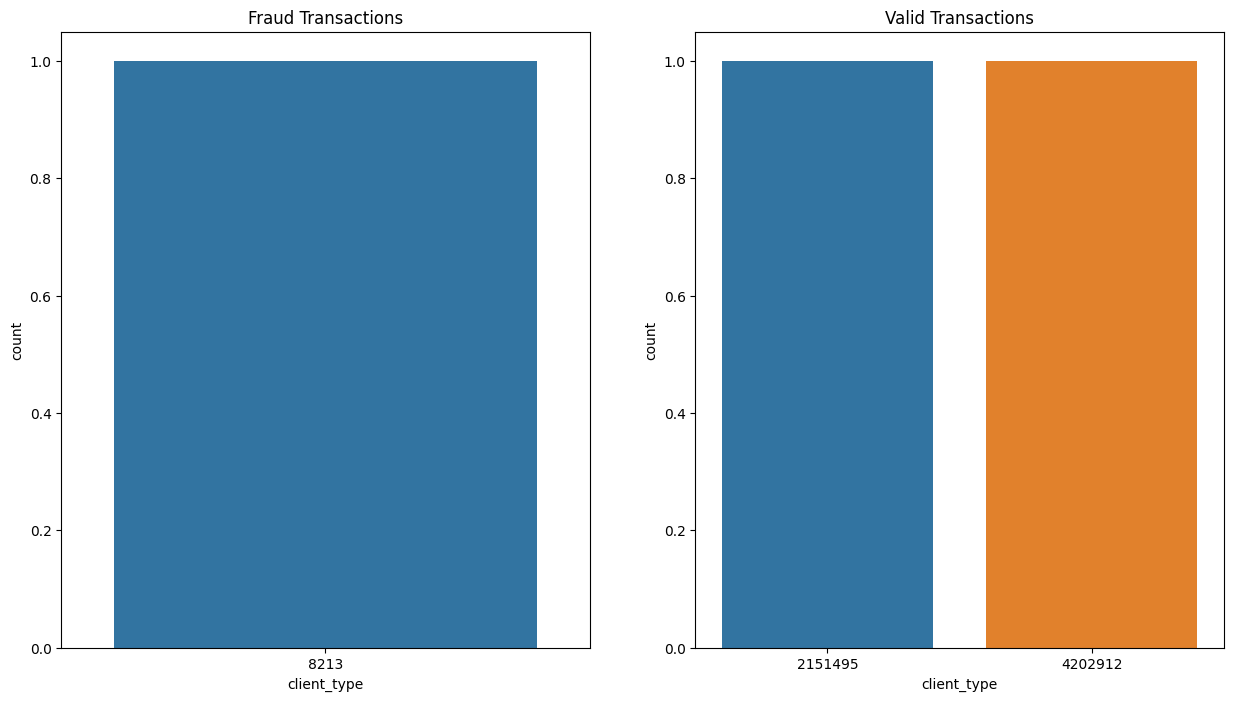

In [28]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
ax1 = sns.countplot(x = fr)
plt.title('Fraud Transactions')

plt.subplot(1,2,2)
ax2 = sns.countplot(x = va)
plt.title('Valid Transactions')

### Visualization of transaction counts categorized by their 'type'

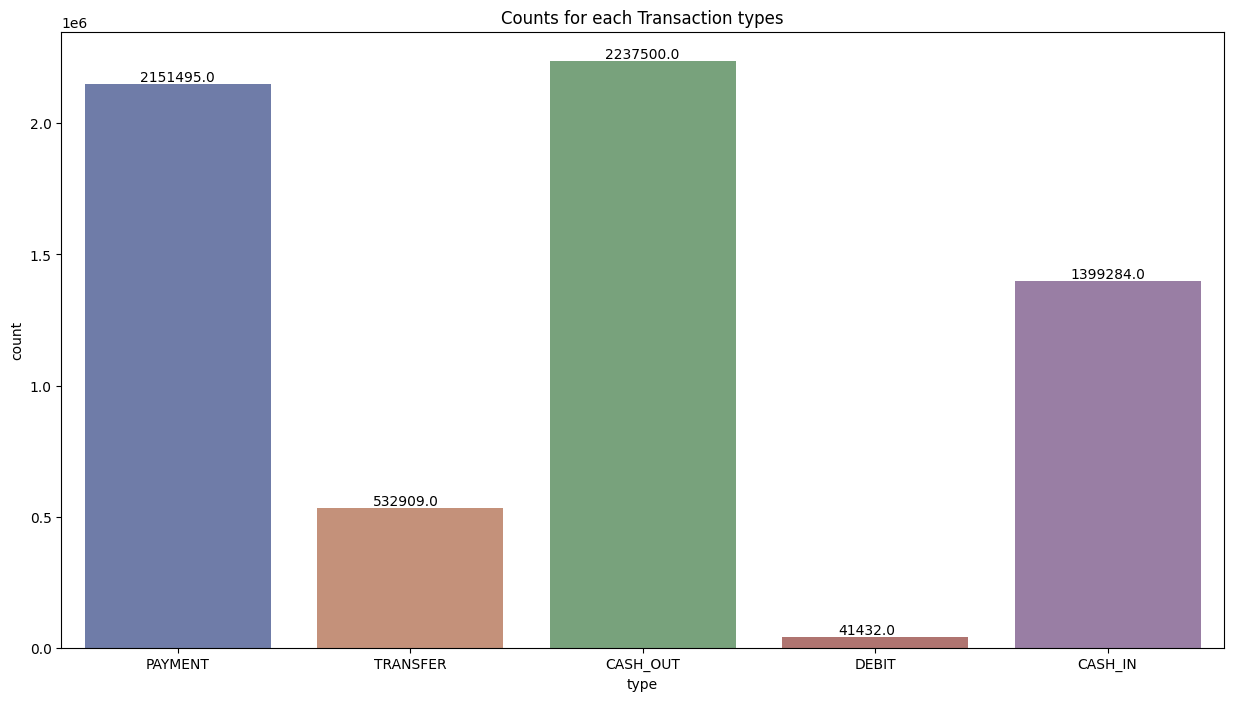

In [29]:
plt.figure(figsize=(15,8))
g = sns.countplot(data=data, x='type', palette='dark',alpha=0.6)
plt.title("Counts for each Transaction types")

#finding counts
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x()+0.24, p.get_height()+10000))

### Visualization of transaction counts categorized by their 'client_type'

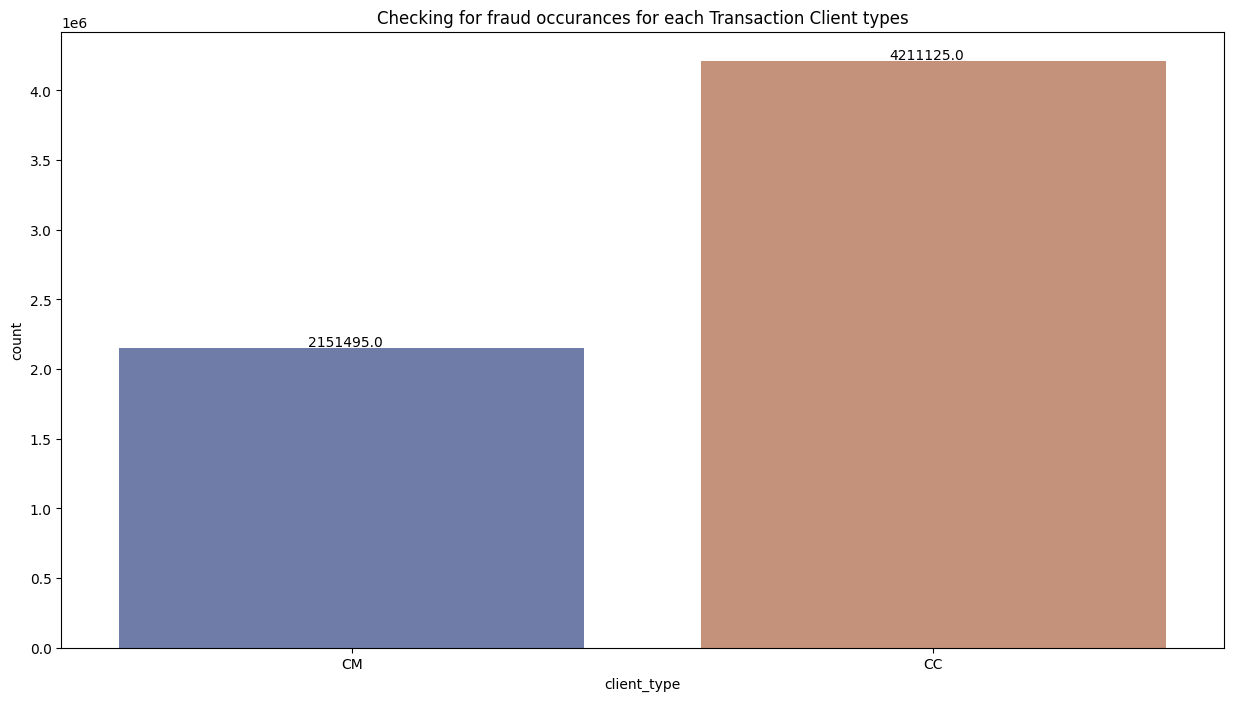

In [30]:
plt.figure(figsize=(15,8))
g = sns.countplot(data=data, x='client_type', palette='dark',alpha=0.6)
plt.title("Checking for fraud occurances for each Transaction Client types")

#finding counts
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x()+0.325, p.get_height()+10000))

### Visualization of Fraud vs Valid transaction counts categorized by their 'client_type'

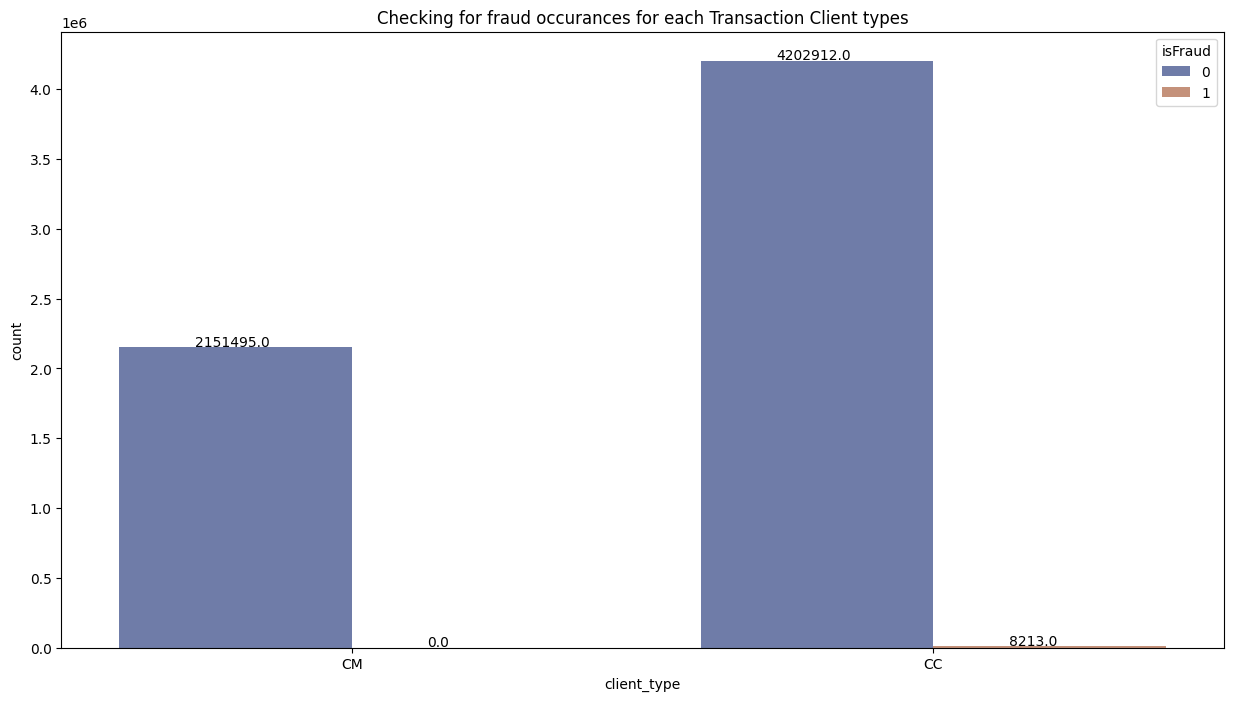

In [31]:
plt.figure(figsize=(15,8))
g = sns.countplot(data=data, x='client_type', hue='isFraud', palette='dark',alpha=0.6)
plt.title("Checking for fraud occurances for each Transaction Client types")

#finding counts
for p in g.patches:
    g.annotate(p.get_height(), (p.get_x()+0.13, p.get_height()+10000))

## Data Preprocessing

### Importing necessary libraries

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Obtaining one-hot encodings for 'type' column

In [33]:
one_hot_type = pd.get_dummies(data['type'])

In [34]:
one_hot_type

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
6362615,0,1,0,0,0
6362616,0,0,0,0,1
6362617,0,1,0,0,0
6362618,0,0,0,0,1


### Adding one-hot encoding for 'type' and removing 'type' column from data

In [35]:
data = data.drop('type', axis=1)

In [36]:
data = data.join(one_hot_type)

In [37]:
data.head()

,amount,sender_old_bal,sender_new_bal,dest_old_bal,dest_new_bal,isFraud,client_type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,CM,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,CM,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,CC,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,CC,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,CM,0,0,0,1,0


### Obtaining one-hot encodings for 'client_type'one_hot_type = pd.get_dummies(data['type']) column

In [38]:
one_hot_client_type = pd.get_dummies(data['client_type'])

In [39]:
one_hot_client_type

,CC,CM
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
6362615,1,0
6362616,1,0
6362617,1,0
6362618,1,0


### Adding one-hot encoding for 'client_type' and removing 'client_type' column from data

In [40]:
data = data.drop('client_type', axis=1)

In [41]:
data = data.join(one_hot_client_type)

In [42]:
data.head()

,amount,sender_old_bal,sender_new_bal,dest_old_bal,dest_new_bal,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,CC,CM
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0,0,1
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0,0,1
2,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1,1,0
3,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0,1,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0,0,1


### Obtaining X and y

In [43]:
y = data.isFraud
X = data.drop('isFraud', axis=1)
print("X:")
print(X.head())
print("y:")
print(y.head())

X:
     amount  sender_old_bal  sender_new_bal  dest_old_bal  dest_new_bal  \
0   9839.64        170136.0       160296.36           0.0           0.0   
1   1864.28         21249.0        19384.72           0.0           0.0   
2    181.00           181.0            0.00           0.0           0.0   
3    181.00           181.0            0.00       21182.0           0.0   
4  11668.14         41554.0        29885.86           0.0           0.0   

   CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  CC  CM  
0        0         0      0        1         0   0   1  
1        0         0      0        1         0   0   1  
2        0         0      0        0         1   1   0  
3        0         1      0        0         0   1   0  
4        0         0      0        1         0   0   1  
y:
0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64


### Train Test split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=data.isFraud)

### Normalizing X_train and X-test

In [45]:
sc = StandardScaler()

In [46]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Machine Learning

### Importing necessary libraries

In [47]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import hamming_loss

### Creating list of ML models

In [49]:
xgbc = xgb.XGBClassifier(max_depth=3, n_jobs=-1, random_state=42, learning_rate=0.1)
rfc = RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42)
lgbmc = LGBMClassifier(boosting_type='gbdt', objective='binary', random_sate=8888)
logreg = LogisticRegression(solver='liblinear', random_state=42)

In [50]:
clsrs = []
clsrs.append(xgbc)
clsrs.append(rfc)
clsrs.append(lgbmc)
clsrs.append(logreg)

### Training ML models

In [51]:
for clsr in clsrs:
    clsr.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: random_sate


### Obtaining prediction and accuracy (hml and auc) calculations

In [52]:
hml_list = []
auc_list = []

In [53]:
for clsr in clsrs:
    y_pred = clsr.predict(X_test)
    y_prob = clsr.predict_proba(X_test)[:,-1]
    hml_list.append(hamming_loss(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_prob))

### Creating accuracy dictionaries

In [54]:
hml_dict = {}
auc_dict = {}
keys = ['XGBoost', 'Random Forest', 'Light GBM', 'LR']

In [55]:
for i in range(len(keys)):
    key = keys[i]
    hml_dict[key] = hml_list[i]
    auc_dict[key] = auc_list[i]

In [56]:
hml_dict_s = dict(sorted(hml_dict.items(), key=lambda item: item[1]))
hml_dict_s

{'LR': 0.0008342475269621633,
 'Random Forest': 0.0010354225146244787,
 'XGBoost': 0.0011523554762031994,
 'Light GBM': 0.0014195410066922117}

In [57]:
auc_dict_s = dict(sorted(auc_dict.items(), key=lambda item: item[1]))
auc_dict_s

{'Light GBM': 0.49363924293312345,
 'Random Forest': 0.7468834320252169,
 'XGBoost': 0.9175496643311672,
 'LR': 0.983744748718957}

### Plotting AUC accuracy scores (Higher AUC score indicates better result)

In [58]:
import plotly
plotly.io.renderers.default = 'png'
#plotly.io.renderers.default = 'jupyterlab'

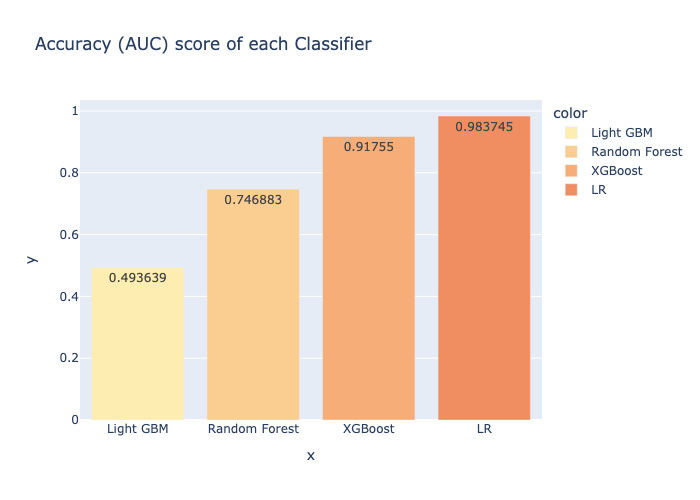

In [59]:
fig = px.bar(x=list(auc_dict_s.keys()), y=list(auc_dict_s.values()), text=np.round(list(auc_dict_s.values()), 6),
            title='Accuracy (AUC) score of each Classifier',color=list(auc_dict_s.keys()),
            color_discrete_sequence=px.colors.sequential.matter)
fig.show()

### Plotting Accuracy (Hamming Loss) scores (Lower score indicates better results)

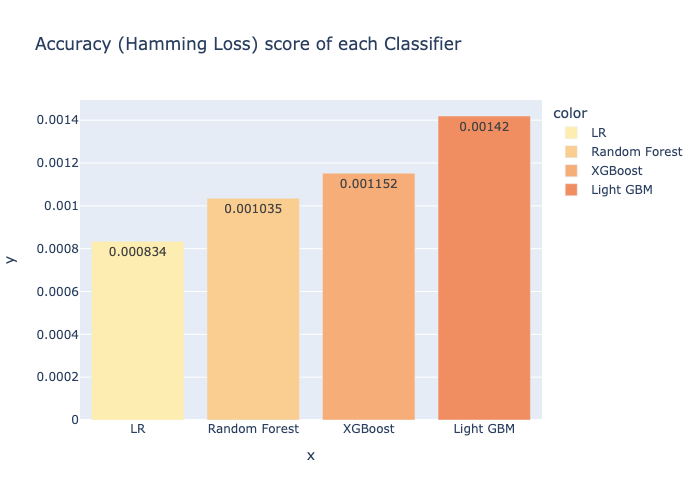

In [60]:
fig = px.bar(x=list(hml_dict_s.keys()), y=list(hml_dict_s.values()), text=np.round(list(hml_dict_s.values()), 6),
            title='Accuracy (Hamming Loss) score of each Classifier',color=list(hml_dict_s.keys()),
            color_discrete_sequence=px.colors.sequential.matter)
fig.show()

### Insights

<ul>
    <li><b>Logistic Regression</b> has the <b>best</b> performance with the - </li>
    <ul>
        <li>best (highest) AUC score - 0.983745</li>
        <li>best (lowest) Hammington Loss score - 0.000834</li>
    </ul>
    <li><b>Light Gradient-Boosting Machine</b> has <b>worst</b> performance with the - </li>
    <ul>
        <li>worst (lowest) AUC score - 0.493639</li>
        <li>worst (highest) Hamming Loss score - 0.00142</li>
    </ul>

## Neural Network

### Deep Neural Network (DNN)

#### Importing Libraries

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### Creating Network

In [62]:
print(X_train.shape)

(4771965, 12)


In [63]:
dnn = Sequential()
dnn.add(Dense(16, input_shape=(12,), activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))

print(dnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
None


#### Compile and Train network

In [64]:
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
dnn.fit(X_train, y_train, epochs=15, batch_size=250, verbose=1, validation_split=0.2)

Epoch 1/15


2023-02-01 15:32:26.823355: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15271/15271 [==============================] - 9s 579us/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 0.9994
Epoch 2/15
15271/15271 [==============================] - 9s 568us/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 3/15
15271/15271 [==============================] - 9s 572us/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 4/15
15271/15271 [==============================] - 9s 574us/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9996
Epoch 5/15
15271/15271 [==============================] - 9s 563us/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 6/15
15271/15271 [==============================] - 9s 568us/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 7/15
15271/15271 [==============================] - 9s 562us/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.002

#### Finding DNN network predictions and prediction probabilities

In [66]:
y_prob = dnn.predict(X_test)

49708/49708 [==============================] - 14s 274us/step


In [67]:
y_pred = []
for y_p in y_prob:
    if y_p >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [68]:
y_pred[0:5]

[0, 0, 0, 0, 0]

In [69]:
y_prob[0:5]

array([[0.0000000e+00],
       [5.2023877e-04],
       [2.5300619e-06],
       [1.0355912e-04],
       [5.5111221e-22]], dtype=float32)

#### Calculating accuracy scores (AUC and Hamming Loss)

In [70]:
dnn_auc = roc_auc_score(y_test, y_prob)
print(f"AUC score is: {dnn_auc}")

AUC score is: 0.9956560590825012


In [71]:
dnn_hml = hamming_loss(y_test, y_pred)
print(f"Hamming Loss is: {dnn_hml}")

Hamming Loss is: 0.0005375144201602485


### Radial Neural Network (RNN)

#### Importing Libraries

In [72]:
from tensorflow.keras.layers import SimpleRNN

#### Reshaping X_train and X_test for use with RNN

In [73]:
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(f"X_train shape is: {X_train_rnn.shape}, X_test shape is: {X_test_rnn.shape}, y_train shape is: {y_train.shape}, y_test shape is: {y_test.shape}")

X_train shape is: (4771965, 1, 12), X_test shape is: (1590655, 1, 12), y_train shape is: (4771965,), y_test shape is: (1590655,)


#### Creating Network

In [74]:
rnn = Sequential()
rnn.add(SimpleRNN(16, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True))
rnn.add(SimpleRNN(32))
rnn.add(Dense(16, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))

print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 16)             464       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,577
Trainable params: 2,577
Non-trainable params: 0
_________________________________________________________________
None


#### Compile and Train Network

In [75]:
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
rnn.fit(X_train_rnn, y_train, epochs=15, batch_size=250, verbose=1, validation_split=0.2)

Epoch 1/15
15271/15271 [==============================] - 17s 1ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 2/15
15271/15271 [==============================] - 15s 985us/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 3/15
15271/15271 [==============================] - 15s 966us/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 4/15
15271/15271 [==============================] - 15s 957us/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 5/15
15271/15271 [==============================] - 15s 970us/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 0.9995
Epoch 6/15
15271/15271 [==============================] - 15s 953us/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 7/15
15271/15271 [==============================] - 15s 954us/step - loss: 0.0025 - accuracy: 0.9995 -

#### Finding RNN network predictions and prediction probabilities

In [77]:
y_prob = rnn.predict(X_test_rnn)

49708/49708 [==============================] - 18s 369us/step


In [78]:
y_pred = []
for y_p in y_prob:
    if y_p >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [79]:
y_pred[0:5]

[0, 0, 0, 0, 0]

In [80]:
y_prob[0:5]

array([[8.3067349e-09],
       [3.6356514e-04],
       [1.2514078e-05],
       [1.5533969e-04],
       [1.9564413e-06]], dtype=float32)

#### Calculating accuracy scores (AUC and Hamming Loss)

In [81]:
rnn_auc = roc_auc_score(y_test, y_prob)
print(f"AUC score is: {rnn_auc}")

AUC score is: 0.9970869596572558


In [82]:
rnn_hml = hamming_loss(y_test, y_pred)
print(f"Hamming Loss is: {rnn_hml}")

Hamming Loss is: 0.0004708752054971065


### Comparing Neural Network accuracy scores

In [83]:
keys = ['DNN', 'RNN']

In [84]:
NN_auc_scrs = []
NN_auc_scrs.append(dnn_auc)
NN_auc_scrs.append(rnn_auc)

In [85]:
NN_hml_scrs = []
NN_hml_scrs.append(dnn_hml)
NN_hml_scrs.append(rnn_hml)

In [86]:
NN_auc_dict = {}
NN_hml_dict = {}

In [87]:
for i in range(len(keys)):
    key = keys[i]
    NN_auc_dict[key] = NN_auc_scrs[i]
    NN_hml_dict[key] = NN_hml_scrs[i]

In [88]:
NN_auc_dict

{'DNN': 0.9956560590825012, 'RNN': 0.9970869596572558}

In [89]:
NN_hml_dict

{'DNN': 0.0005375144201602485, 'RNN': 0.0004708752054971065}

#### Plotting AUC accuracy scores (Higher AUC score indicates better result)

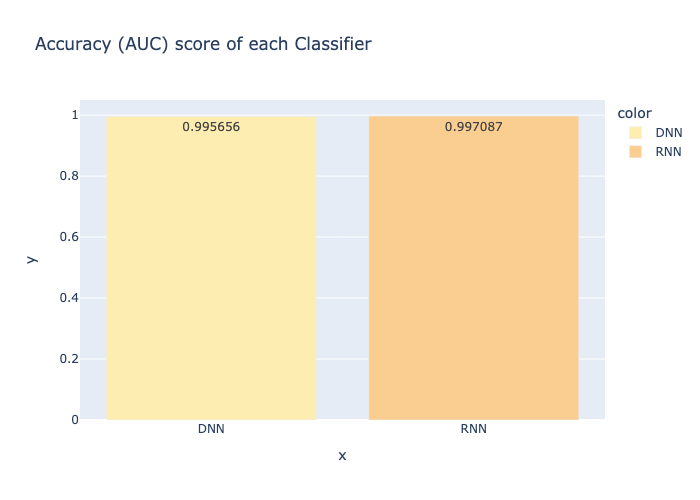

In [90]:
fig = px.bar(x=list(NN_auc_dict.keys()), y=list(NN_auc_dict.values()), text=np.round(list(NN_auc_dict.values()), 6),
            title='Accuracy (AUC) score of each Classifier',color=list(NN_auc_dict.keys()),
            color_discrete_sequence=px.colors.sequential.matter)
fig.show()

### Plotting Accuracy (Hamming Loss) scores (Lower score indicates better results)

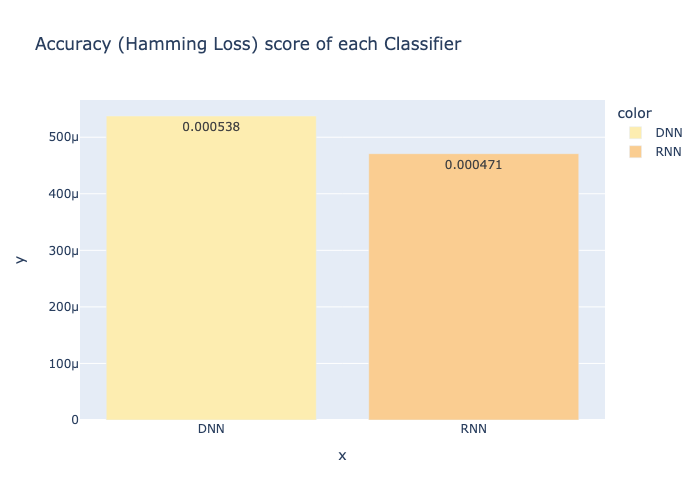

In [91]:
fig = px.bar(x=list(NN_hml_dict.keys()), y=list(NN_hml_dict.values()), text=np.round(list(NN_hml_dict.values()), 6),
            title='Accuracy (Hamming Loss) score of each Classifier',color=list(NN_hml_dict.keys()),
            color_discrete_sequence=px.colors.sequential.matter)
fig.show()

### Insights

<ul>
    <li><b>RNN</b> performs better than <b>DNN</b> - </li>
    <ul>
        <li>RNN has the better (higher) AUC score </li>
        <li>RNN has the better (lower) Hammington Loss score </li>

## Combining ML and NN results

### AUC score case

In [92]:
auc_comb_dict = auc_dict
auc_comb_dict.update(NN_auc_dict)

In [93]:
auc_comb_dict_s = dict(sorted(auc_comb_dict.items(), key=lambda item: item[1]))
auc_comb_dict_s

{'Light GBM': 0.49363924293312345,
 'Random Forest': 0.7468834320252169,
 'XGBoost': 0.9175496643311672,
 'LR': 0.983744748718957,
 'DNN': 0.9956560590825012,
 'RNN': 0.9970869596572558}

### Hammington Loss score case

In [94]:
hml_comb_dict = hml_dict
hml_comb_dict.update(NN_hml_dict)

In [95]:
hml_comb_dict_s = dict(sorted(hml_comb_dict.items(), key=lambda item: item[1]))
hml_comb_dict_s

{'RNN': 0.0004708752054971065,
 'DNN': 0.0005375144201602485,
 'LR': 0.0008342475269621633,
 'Random Forest': 0.0010354225146244787,
 'XGBoost': 0.0011523554762031994,
 'Light GBM': 0.0014195410066922117}

### Visualizing combined accuracy score results

#### Plotting AUC accuracy scores (Higher AUC score indicates better result)

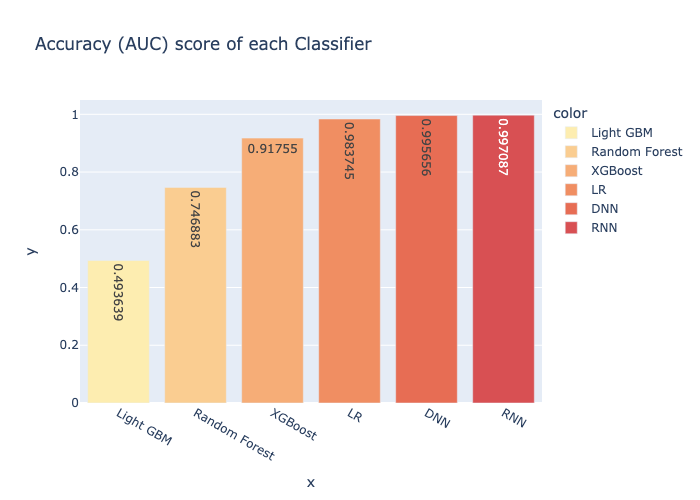

In [96]:
fig = px.bar(x=list(auc_comb_dict_s.keys()), y=list(auc_comb_dict_s.values()), text=np.round(list(auc_comb_dict_s.values()), 6),
            title='Accuracy (AUC) score of each Classifier',color=list(auc_comb_dict_s.keys()),
            color_discrete_sequence=px.colors.sequential.matter)
fig.show()

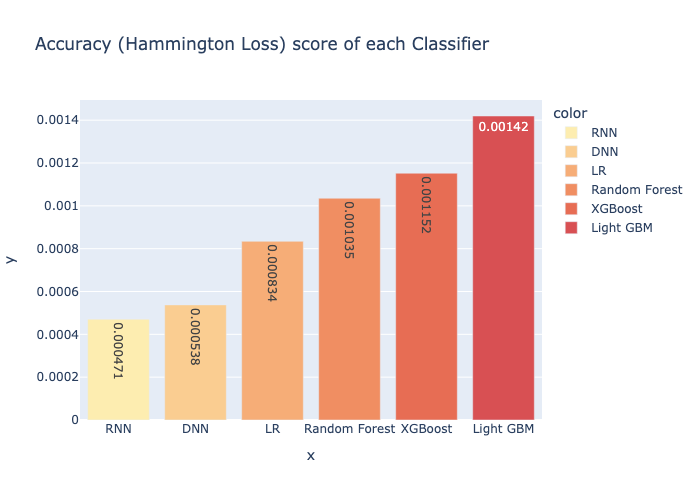

In [97]:
fig = px.bar(x=list(hml_comb_dict_s.keys()), y=list(hml_comb_dict_s.values()), text=np.round(list(hml_comb_dict_s.values()), 6),
            title='Accuracy (Hammington Loss) score of each Classifier',color=list(hml_comb_dict_s.keys()),
            color_discrete_sequence=px.colors.sequential.matter)
fig.show()

### Insights

<ul>
    <li>Both Neural Networks have better performances than any of the ML models (as expected)</li>
    <li>Out of the four ML models and two Neural Networks tried, <b>RNN</b> has the best performance</li>
</ul>

## Summary

<ul>
    <li>Fraud transactions only for 'TRANSFER' and 'CASH_OUT' transcation types</li>
    <li>Fraud transactions only to and from customers</li>
    <li>Recipient account for fraud 'TRANSFER' transactions used 4097 times to make valis cash withdrawals</li>
    <li>Four ML models were used for prediction - </li>
    <ul>
        <li>Logistic Regression: AUC - 0.983745, Hammington Loss - 0.000834</li>
        <li>Random Forest: AUC - 0.746883, Hammington Loss - 0.001035</li>
        <li>Extreme Gradient Boost: AUC - 0.91755, Hammington Loss - 0.001152</li>
        <li>Light Gradient-Boosting Machine: AUC - 0.493639, Hammington Loss - 0.00142</li>
        <li><b>Logistic Regression</b> has the best performance and <b>Light Gradient-Boosting Machine</b> the worst
    </ul>
    <li>Two Neural Networks were used for prediction - </li>
    <ul>
        <li>DNN: AUC - 0.995656, Hammington Loss - 0.000538</li>
        <li>RNN: AUC - 0.997087, Hammington Loss - 0.000471</li>
        <li><b>RNN</b> performs better than <b>DNN</b></li>
    </ul>
    <li>Neural Networks perform better than Machine Learning models in general - as expected</li>

## NOTE:

<ul>
    <li><b>AUC score</b> - The higher the AUC score, the better the model's performance at distinguishing between the true and false classes.</li>
    <li><b>Hammington Loss score</b> - Fraction of labels that are predicted incorrectly. So lower the score the better the model/network performance.</li>
</ul>

<ul>
    <li><b>Data obtained from</b> - https://www.kaggle.com/datasets/ealaxi/paysim1</li>
    <li><b>Work heavily inspired by</b> - https://www.kaggle.com/code/waleedfaheem/credit-card-fraud-detection-auc-0-9
    <br>Main differences - </br></li>
    <ul>
        <li>Neural Networks included for prediction purposes</li>
        <li>Minor differences in observations/findings</li>
        <li>Different accuracy metrics used for determining model/network performances</li>
    </ul>
</ul>